In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

# TensorFlow and tf.keras
import tensorflow as tf
import sys
print(tf.__version__)
print(sys.version)

2.16.1
3.12.5 (tags/v3.12.5:ff3bc82, Aug  6 2024, 20:45:27) [MSC v.1940 64 bit (AMD64)]


In [2]:
train_im = np.load('C:/THINGS/SVARBU/wur maybe/uni/year5/darbas/vasara/pics.npy')
train_lab = np.load('C:/THINGS/SVARBU/wur maybe/uni/year5/darbas/vasara/labs.npy')
train_im.shape

(37, 128, 128, 1)

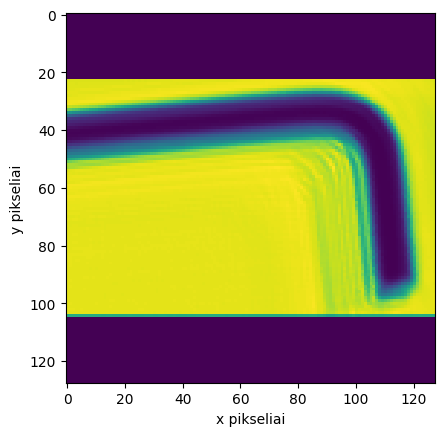

In [22]:
num =32
image = train_im[num]

plt.imshow(image, interpolation='nearest')
#plt.colorbar()
#plt.title('Originalus paveikslėlis')
plt.xlabel('x pikseliai')
plt.ylabel('y pikseliai')
plt.show()

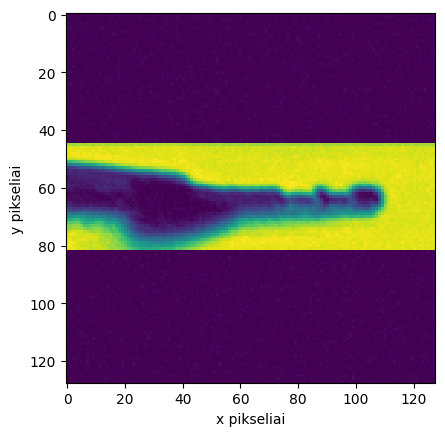

0


In [4]:
sigma = 0.01
gaussian = np.random.normal(0, sigma, (image.shape[0], image.shape[1], 1)) 
noisy_image = image + gaussian
noisy_image = tf.clip_by_value(noisy_image, 0, 1)
plt.imshow(noisy_image, interpolation='nearest')
#plt.colorbar()
#plt.title(r'$\sigma$ = 0.01')
plt.xlabel('x pikseliai')
plt.ylabel('y pikseliai')
plt.show()
print(train_lab[num])

In [5]:
BATCH_SIZE = 4
SHUFFLE_BUFFER_SIZE = 50


train_lab =  train_lab.astype('int8')
train_dataset = tf.data.Dataset.from_tensor_slices((train_im, train_lab)).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
train_im = 0
train_lab = 0

#test_dataset = tf.data.Dataset.from_tensor_slices((test_im, test_lab)).batch(BATCH_SIZE)

#test_im = 0
#test_lab = 0

In [28]:
def noise(x):
    noise = tf.random.normal(shape=tf.shape(x), mean=0.0, stddev=0.02, dtype=tf.float32)
    x = x + noise
    x = tf.clip_by_value(x, 0.0, 1.0)
    return x

In [29]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomTranslation(height_factor=0.2, 
                                      width_factor=0),
    tf.keras.layers.RandomRotation(factor = 1,
                                   fill_mode="constant"),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomFlip("vertical"),
  ]
)

In [44]:
def make_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    
    noised = tf.keras.layers.Lambda(noise)(inputs)
    x = data_augmentation(noised)
    
    x = tf.keras.layers.Conv2D(16, 3, padding='same', activation='elu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Conv2D(32, 3, padding='same', activation='elu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='elu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    
    outputs = tf.keras.layers.Dense(2)(x)
    return tf.keras.Model(inputs, outputs)
    
model = make_model(input_shape=(128, 128, 1))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [48]:
epochs=50
history = model.fit(
  train_dataset,
  validation_data=test_dataset,
  epochs=epochs
)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9288 - loss: 0.1979 - val_accuracy: 0.8519 - val_loss: 0.3421
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9260 - loss: 0.1912 - val_accuracy: 0.8519 - val_loss: 0.3192
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9275 - loss: 0.1874 - val_accuracy: 0.8889 - val_loss: 0.3394
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9205 - loss: 0.1282 - val_accuracy: 0.9259 - val_loss: 0.2711
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9317 - loss: 0.2070 - val_accuracy: 0.8889 - val_loss: 0.2641
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8418 - loss: 0.4179 - val_accuracy: 0.8519 - val_loss: 0.3026
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9308 - loss: 0.2230 - val_accuracy: 0.8519 - val_loss: 0.3022
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8849 - loss: 0.2019 - val_accuracy: 0.8889 - val_loss:

In [51]:
test_im = np.load('C:/THINGS/SVARBU/wur maybe/uni/year5/darbas/vasara/test_pics.npy')
test_lab = np.load('C:/THINGS/SVARBU/wur maybe/uni/year5/darbas/vasara/test_labs.npy')

test_dataset = tf.data.Dataset.from_tensor_slices((test_im, test_lab)).batch(BATCH_SIZE)

model.evaluate(test_dataset)

probability_model = tf.keras.Sequential([model,
                                         tf.keras.layers.Softmax()])

predictions = probability_model.predict(test_im)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9715 - loss: 0.2149
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


[0.26747534 0.7325246 ]


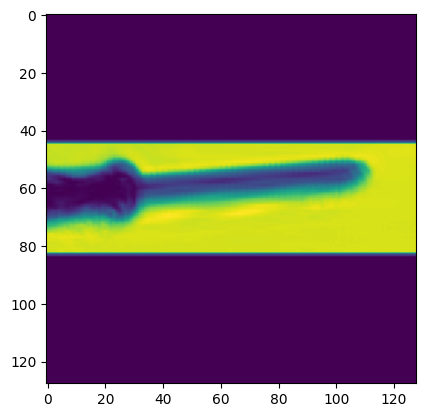

[0.30111298 0.698887  ]


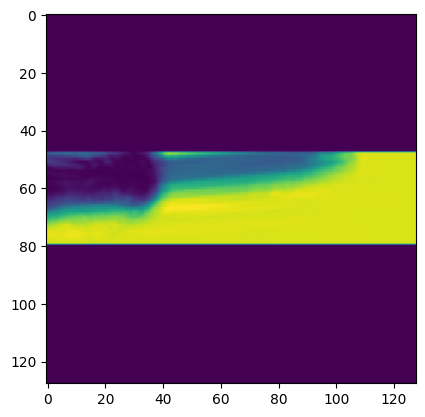

[0.00747292 0.9925271 ]


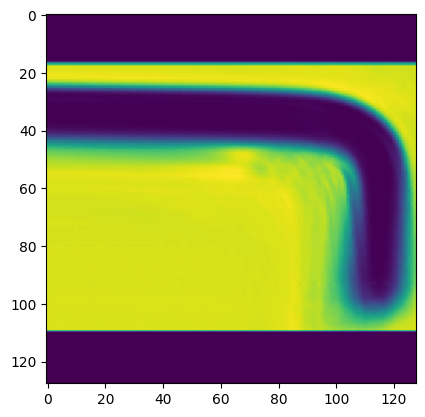

[0.22463956 0.77536047]


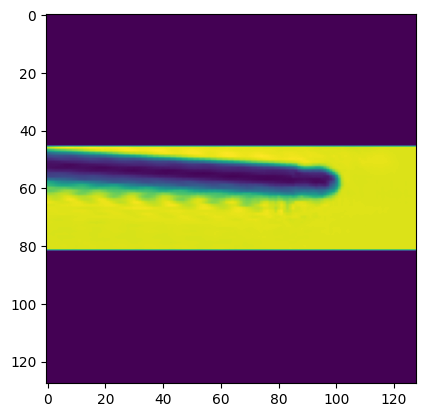

[0.81370646 0.18629354]


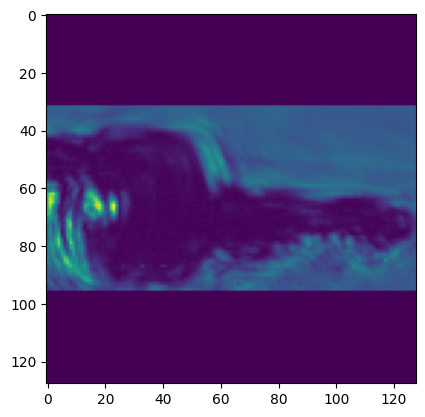

[0.5605898 0.4394102]


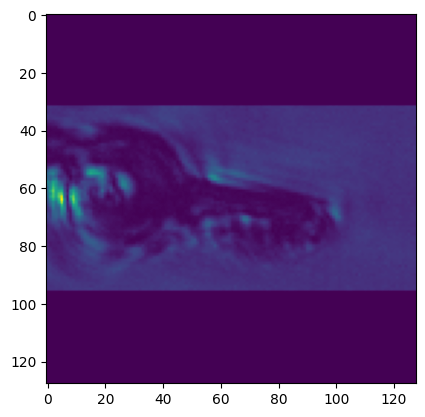

[9.9961382e-01 3.8618268e-04]


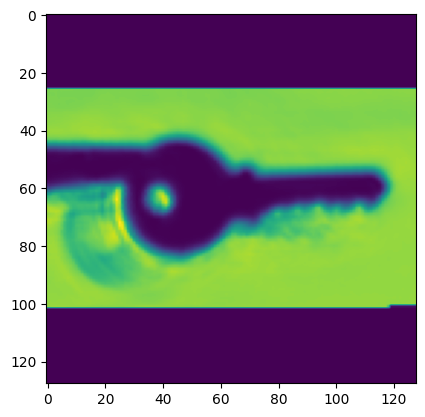

[0.8359827  0.16401736]


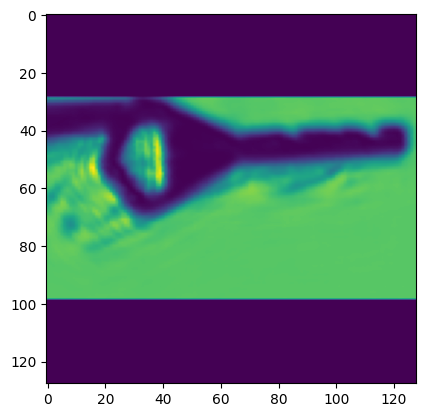

[0.551794   0.44820607]


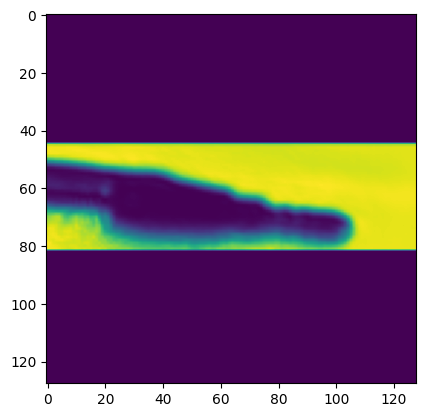

[0.99508923 0.00491075]


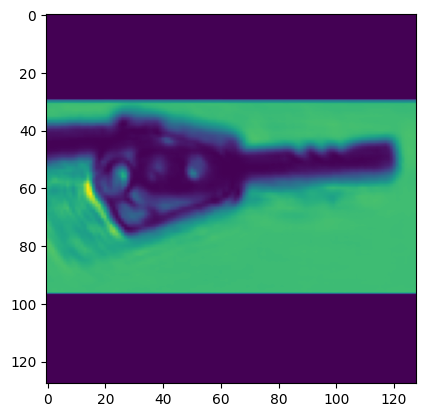

[0.95232815 0.04767184]


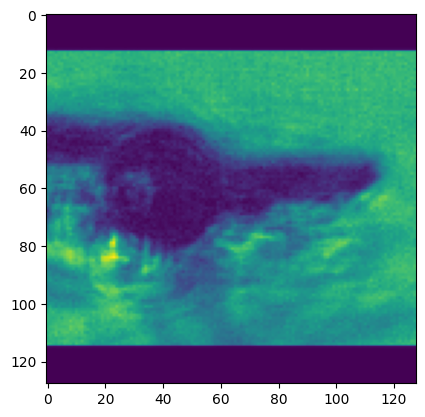

[0.98659825 0.01340173]


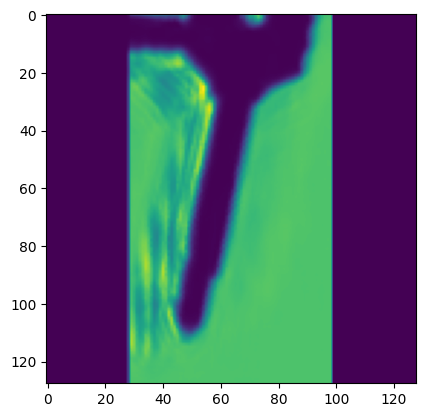

[0.5814464 0.4185536]


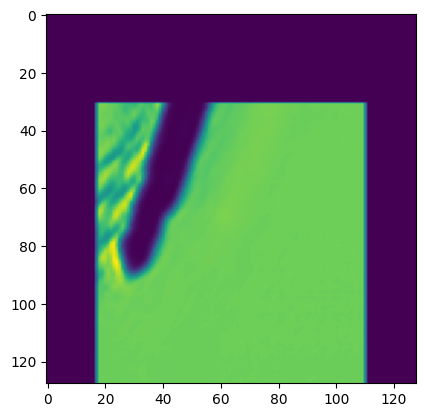

[0.29485154 0.70514846]


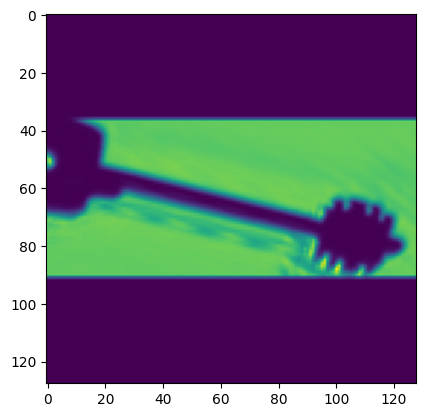

[0.9224434  0.07755656]


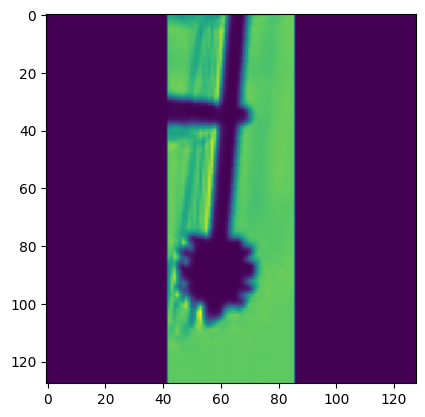

[0.9853456  0.01465431]


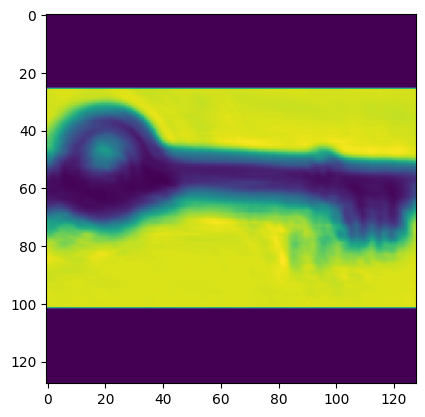

[0.9447484  0.05525161]


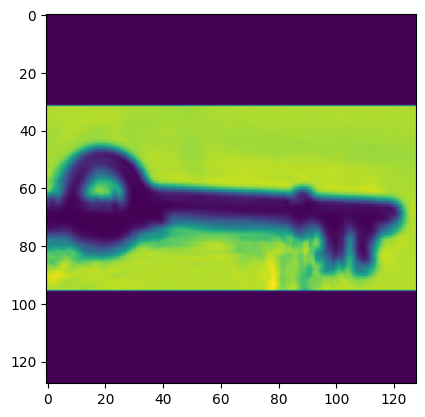

[0.9988487  0.00115134]


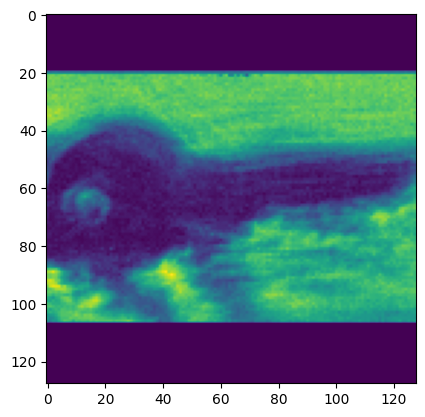

[0.99811316 0.00188682]


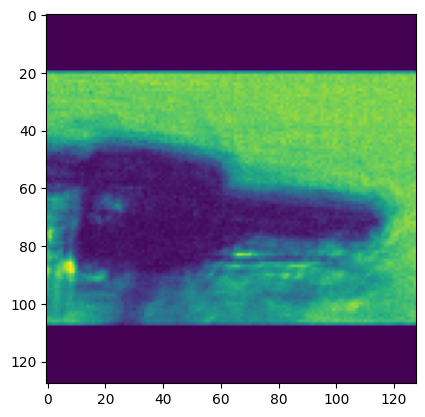

[0.99179924 0.00820082]


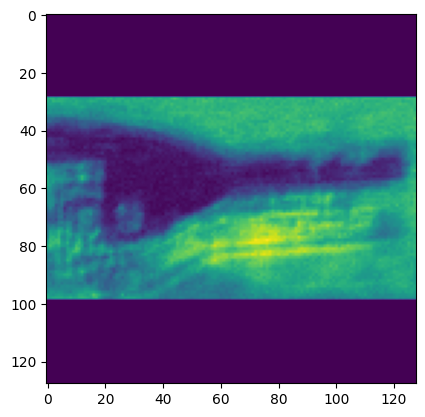

[0.9960258  0.00397415]


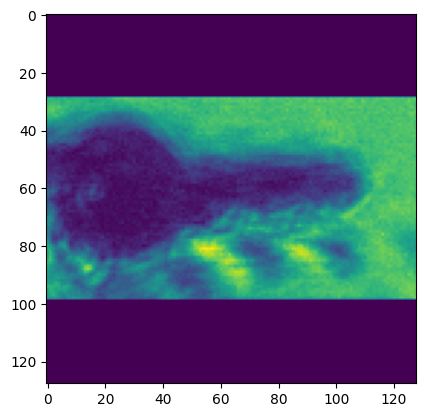

[0.9857815  0.01421853]


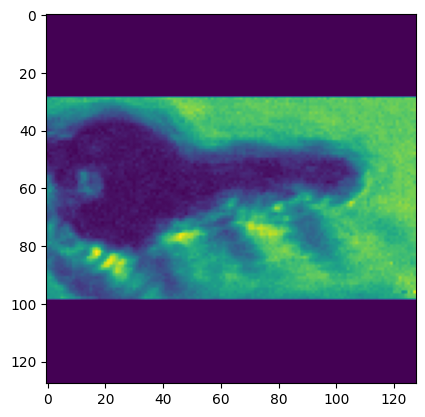

[0.9903937 0.0096063]


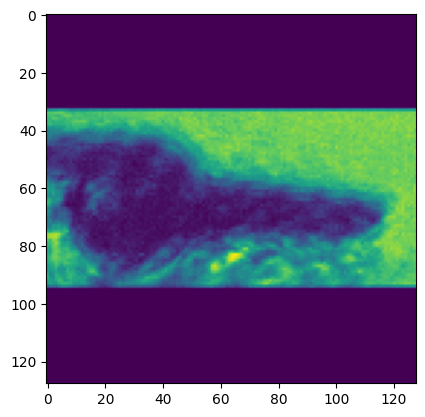

[0.99499965 0.00500038]


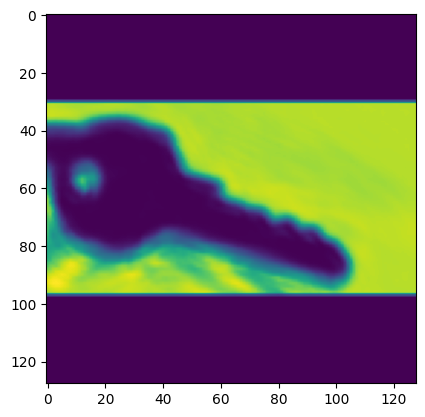

[0.9966685 0.0033315]


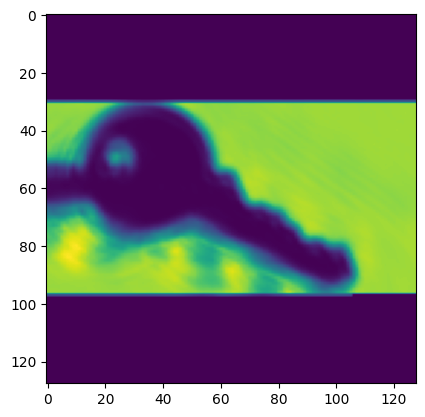

[9.9999654e-01 3.4019156e-06]


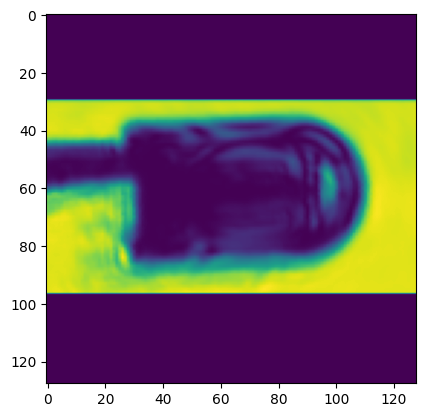

[0.98677295 0.01322706]


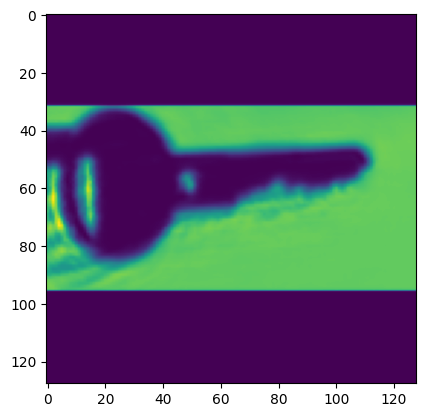

In [52]:
i = 0
for element in test_im:
    print(predictions[i])
    plt.imshow(test_im[i])
    plt.show()
    i=i+1

In [53]:
i

27